# ENSF 592 - FINAL PROJECT
## Calgary Accident Analysis
### By: Mike Lasby

# README
This notebook is the entry point of our project and functions as the View. The notebook depends on the Controller.py class to retrieve and manipulate data from the underlying data models stored as seperate .py scripts. 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from geojson import Point, MultiLineString
import geopandas as gpd
# from shapely.geometry import Point, MultiLineString, LineString
import re
import math
import folium
import matplotlib.pyplot as plt

In [2]:
incidents_df = pd.read_csv('Traffic_Incidents.csv')
speeds_df = pd.read_csv('Speed_Limits.csv')
cameras_df = pd.read_csv('Traffic_Camera_Locations.csv')
signals_df = pd.read_csv('Traffic_Signals.csv')
signs_df = pd.read_csv('Traffic_Signs.csv')
volumes_df = pd.read_csv('Traffic_Volumes_for_2018.csv')

In [3]:
incidents_df

,INCIDENT INFO,DESCRIPTION,START_DT,MODIFIED_DT,QUADRANT,Longitude,Latitude,location,Count,id
0,Westbound McKnight Boulevard approaching John ...,2 vehicle incident.,12/09/2016 04:46:32 PM,12/09/2016 05:16:54 PM,NW,-114.083318,51.097316,"(51.09731625733, -114.083317961464)",1,2016-12-09T16:46:3251.0973162573297-114.083317...
1,20 Avenue at 8 Street NW,2 vehicle incident.,12/09/2016 04:58:23 PM,12/09/2016 05:16:54 PM,NW,-114.081378,51.070539,"(51.070538552637, -114.081377719156)",1,2016-12-09T16:58:2351.0705385526371-114.081377...
2,Sunridge Way at 36 Street NE,There is an incident involving LRT.,12/09/2016 05:14:08 PM,12/09/2016 05:16:54 PM,NE,-113.984934,51.067299,"(51.067298691023, -113.98493374196)",1,2016-12-09T17:14:0851.0672986910231-113.984933...
3,Westbound Stoney approaching Shaganappi Trail NW.,Multi vehicle incident.,12/09/2016 05:16:08 PM,12/09/2016 05:16:53 PM,NW,-114.147933,51.152736,"(51.152736445625, -114.147933369876)",1,2016-12-09T17:16:0851.1527364456253-114.147933...
4,Southbound Nose Hill Drive approaching Crowchi...,Multi vehicle incident.,12/09/2016 05:38:05 PM,12/09/2016 05:55:52 PM,NW,-114.203241,51.119684,"(51.11968378497, -114.203240843777)",1,2016-12-09T17:38:0551.1196837849704-114.203240...
...,...,...,...,...,...,...,...,...,...,...
19783,Southbound Deerfoot Trail and Douglasdale Bou...,Multi-vehicle incident. Blocking the right lane,07/11/2020 07:21:57 PM,NaN,NaN,-114.005304,50.946741,"(50.94674131426537, -114.00530375385111)",1,2020-07-11T19:21:5750.94674131426537-114.00530...
19784,Shawnessy Boulevard and Shawville Boulevard SE,Two vehicle incident. Blocking multiple lanes.,07/11/2020 10:29:09 PM,NaN,NaN,-114.069753,50.912974,"(50.91297382324482, -114.06975311526708)",1,2020-07-11T22:29:0950.91297382324482-114.06975...
19785,Eastbound Stoney Trail after Shaganappi Trail...,Traffic incident.,07/11/2020 11:26:45 PM,NaN,NaN,-114.150728,51.152731,"(51.15273080944574, -114.15072838091025)",1,2020-07-11T23:26:4551.15273080944574-114.15072...
19786,Symons Valley Road NW and 144 Avenue NW,Traffic incident. The road is closed between ...,07/12/2020 08:34:16 AM,NaN,NaN,-114.134978,51.183220,"(51.18321993655643, -114.13497799337898)",1,2020-07-12T08:34:1651.18321993655643-114.13497...


In [4]:
# filt = speeds_df['SPEED'] == 50
# speeds_df.loc[filt]
speeds_df

,BOUND,CREATED_DT,DISTANCE,SPEED,STREET_NAME,multiline
0,N,NaN,0.81,60,MILLSIDE BV SE,MULTILINESTRING ((-114.073657541927 50.9135772...
1,NaN,2018/10/30,NaN,40,DEERFOOT TR SE RAMP,MULTILINESTRING ((-114.034764352652 50.9962241...
2,S,2018/10/23,NaN,60,HARVEST HILLS BV N,MULTILINESTRING ((-114.068566084381 51.1667137...
3,N,2019/10/09,4.37,70,CROWCHILD TR SW,MULTILINESTRING ((-114.117825190175 51.0050022...
4,NaN,2018/10/30,NaN,80,STONEY TR NE RAMP,MULTILINESTRING ((-113.918850808952 51.0624482...
...,...,...,...,...,...,...
1447,S,2018/10/29,NaN,80,STONEY TR NW,MULTILINESTRING ((-114.233241861102 51.0915352...
1448,N/S,2018/10/31,NaN,70,37 ST SW,MULTILINESTRING ((-114.140309947853 50.9177590...
1449,W,2018/11/02,NaN,60,SUN VALLEY BV SE,MULTILINESTRING ((-114.030210417675 50.9043134...
1450,E,NaN,1.85,60,JOHN LAURIE BV,MULTILINESTRING ((-114.177870798005 51.1241752...


In [5]:
cameras_df

,Camera Location,Quadrant,Camera URL,longitude,latitude
0,Stoney Trail / Deerfoot Trail SE,SE,http://trafficcam.calgary.ca/loc86.jpg,-113.976606,50.900726
1,Memorial Drive / 52 Street E,NE,http://trafficcam.calgary.ca/loc3.jpg,-113.955818,51.053253
2,Crowchild Trail / Shaganappi Trail NW,NW,http://trafficcam.calgary.ca/loc37.jpg,-114.149379,51.098849
3,Crowchild Trail / Sarcee Trail NW,NW,http://trafficcam.calgary.ca/loc126.jpg,-114.178204,51.111255
4,Airport Trail / Barlow Trail NE,NE,http://trafficcam.calgary.ca/loc114.jpg,-114.001451,51.139352
...,...,...,...,...,...
121,Memorial Drive / Edmonton Trail NE,NE,http://trafficcam.calgary.ca/loc30.jpg,-114.050136,51.050802
122,Glenmore Trail / Barlow Trail SE,SE,http://trafficcam.calgary.ca/loc98.jpg,-113.981495,50.979446
123,Glenmore Trail / Stoney Trail SE,SE,http://trafficcam.calgary.ca/loc128.jpg,-113.929263,50.979635
124,5 Avenue / 5 Street SW,SW,http://trafficcam.calgary.ca/loc122.jpg,-114.073644,51.048677


In [6]:
signals_df

,INSTDATE,FIRSTROAD,SECONDROAD,QUADRANT,INT_TYPE,PEDBUTTONS,PED_TIMER,ACCESSIBLE PEDESTRIAN SIGNAL,latitude,longitude,Point,Count
0,1969/04/01,KENSINGTON ROAD,12 STREET,NW,Overhead Flasher,Yes,No,NaN,51.052514,-114.091740,POINT (-114.091739730382 51.052513524679),1
1,2005/02/09,COUNTRY HILLS BOULEVARD,COVENTRY HILLS BOULEVARD,NE,Traffic signal T intersection,Yes,No,NaN,51.154211,-114.052475,POINT (-114.05247454616 51.154210611434),1
2,2000/11/13,McCALL WAY,PEGASUS ROAD,NE,Traffic signal,Yes,No,NaN,51.094081,-114.011478,POINT (-114.011477743314 51.094081325343),1
3,1973/01/01,72 AVENUE,CENTRE STREET,N,Traffic signal,Yes,No,NaN,51.117992,-114.069588,POINT (-114.069587594341 51.11799160169),1
4,1957/01/01,9 AVENUE,15 STREET/17 AVENUE,SE,Traffic signal,Yes,No,NaN,51.037739,-114.025122,POINT (-114.025122275833 51.037738985756),1
...,...,...,...,...,...,...,...,...,...,...,...,...
1533,2017/08/03,COUNTRY HILLS BOULEVARD,ROCKY RIDGE RECREATIONAL FACILITY,NW,Traffic signal T intersection,Yes,No,NaN,51.154147,-114.228956,POINT (-114.228956047964 51.15414689593),1
1534,2017/04/12,BRIDLERIDGE WAY,BRIDLEWOOD ROAD,SW,Pedestrian RRFB,Yes,No,NaN,50.902069,-114.109199,POINT (-114.109199438382 50.902068514229),1
1535,1966/08/01,10 STREET,23 AVENUE,NW,Overhead Flasher,Yes,No,NaN,51.073213,-114.084589,POINT (-114.084588882838 51.073213223999),1
1536,1956/01/01,5 AVENUE,1 STREET,SE,Traffic signal,No,Yes,NaN,51.048341,-114.060387,POINT (-114.060387455583 51.048340950291),1


In [7]:
signs_df

,BLADE_TYPE,COMMENTS,FACING_CD,FLD_SRC_TXT,INSTDATE,MATERIAL,PL_TY,REUSE,SGN_COUNT_NO,SGN_STA_CD,...,STA_CD,SIZE_CD,SUPPORTTYPE,UNITID,TE_SIGNLOCATION_UNITID,POINT,Ward Boundaries,City Quadrants,Calgary Communities,Ward Boundaries 2013-2017
0,Regulatory,NaN,N,NaN,2007/07/01,NaN,NaN,NaN,1.0,A,...,A,60X75,NaN,1.109184e+09,1109082667,POINT (-114.210957448601 51.0685668243),1.0,1.0,128.0,14.0
1,Parking Restrictions,NaN,W,GPS,2016/08/18,High Intensity,SG_40-06,NaN,0.0,R,...,R,30X30,Signpole,1.110021e+09,1110021182,POINT (-113.935804152861 50.911165903496),4.0,3.0,96.0,8.0
2,Timed Parking,NaN,NE,Field Estimate,NaN,NaN,SG_40-05,NaN,4.0,A,...,R,SPECIAL,Signpole,1.110202e+09,1109526373,POINT (-114.05423120852 51.042027593481),14.0,3.0,260.0,5.0
3,Timed Parking,NaN,NE,Field Estimate,2019/01/16,High Intensity,SG_40-05,NaN,4.0,A,...,A,SPECIAL,Signpole,1.110202e+09,1109286994,POINT (-114.053597489366 51.04135079758),14.0,3.0,260.0,5.0
4,Warning,NaN,W,Field Estimate,2018/09/12,High Intensity,SG_40-57,NaN,0.0,A,...,A,NaN,Signpole,1.110271e+09,1110172249,POINT (-113.935926247512 50.911341384981),4.0,3.0,96.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207515,Street Name,NaN,E,GPS,2005/07/01,High Intensity,NaN,NaN,1.0,A,...,A,30XL,Trunk,1.109144e+09,1109076036,POINT (-114.089566544877 50.91413523827),5.0,1.0,156.0,6.0
207516,Regulatory,NaN,N,Field Estimate,2015/06/10,High Intensity,SG_40-05,NaN,3.0,A,...,A,SPECIAL,Signpole,1.109942e+09,1109941864,POINT (-114.073475226496 51.050465695905),14.0,1.0,262.0,2.0
207517,Parking Restrictions,NaN,SW,Field Estimate,2008/07/03,NaN,SG_40-06,NaN,3.0,A,...,A,30X45,Signpole,1.109276e+09,1109276231,POINT (-114.090109343345 51.052801038311),7.0,2.0,40.0,7.0
207518,Street Name,NaN,NW/SE,GPS,2004/07/01,High Intensity,SG_40-99,NaN,2.0,A,...,A,15XL,Signpole,1.109230e+09,1109092275,POINT (-114.053874443342 50.974157960171),10.0,3.0,174.0,5.0


In [8]:

def clean_multi_line(s: str, flip = True):
    '''
    get coordinates from string data and convert to geojson multiline string object 
    '''
    cleaned = list(map(float,re.findall(r'[\-?\d\.?]+', s)))
    if flip:
        cleaned = flip_coords(cleaned)
    return MultiLineString(cleaned)

def flip_coords(coords):
    flipped = []
    lats = [] 
    lons = []
    i = 0
    while i < len(coords):
        if i % 2 == 0: 
            lons.append(coords[i])
        else:  
            lats.append(coords[i])
        i+=1
    flipped = list(zip(lats,lons))
    return flipped

def clean_point_coords(s: str, flip=True): 
    cleaned = list(map(float,re.findall(r'[\-\d\.?]+', s)))
    # print(cleaned)
    if flip:
        cleaned = flip_coords(cleaned)
    return Point(cleaned)

display(signals_df['Point'].apply(lambda x: clean_point_coords(x)))
# display(signs_df['POINT'].apply(lambda x: clean_point_coords(x)))
display(incidents_df['location'].apply(lambda x: clean_point_coords(x, flip=False)))

display(volumes_df['multilinestring'].apply(lambda x: clean_multi_line(x)))
display(speeds_df['multiline'].apply(lambda x: clean_multi_line(x)))
cameras_df['Point'] = list(zip(cameras_df['latitude'], cameras_df['longitude']))
cameras_df['Point'] = cameras_df['Point'].apply(lambda x: Point(x))
display(cameras_df)



0       {'type': 'Point', 'coordinates': [[51.052514, ...
1       {'type': 'Point', 'coordinates': [[51.154211, ...
2       {'type': 'Point', 'coordinates': [[51.094081, ...
3       {'type': 'Point', 'coordinates': [[51.117992, ...
4       {'type': 'Point', 'coordinates': [[51.037739, ...
                              ...                        
1533    {'type': 'Point', 'coordinates': [[51.154147, ...
1534    {'type': 'Point', 'coordinates': [[50.902069, ...
1535    {'type': 'Point', 'coordinates': [[51.073213, ...
1536    {'type': 'Point', 'coordinates': [[51.048341, ...
1537    {'type': 'Point', 'coordinates': [[50.906049, ...
Name: Point, Length: 1538, dtype: object

0        {'type': 'Point', 'coordinates': [51.097316, -...
1        {'type': 'Point', 'coordinates': [51.070539, -...
2        {'type': 'Point', 'coordinates': [51.067299, -...
3        {'type': 'Point', 'coordinates': [51.152736, -...
4        {'type': 'Point', 'coordinates': [51.119684, -...
                               ...                        
19783    {'type': 'Point', 'coordinates': [50.946741, -...
19784    {'type': 'Point', 'coordinates': [50.912974, -...
19785    {'type': 'Point', 'coordinates': [51.152731, -...
19786    {'type': 'Point', 'coordinates': [51.18322, -1...
19787    {'type': 'Point', 'coordinates': [51.047762, -...
Name: location, Length: 19788, dtype: object

0       {'type': 'MultiLineString', 'coordinates': [[5...
1       {'type': 'MultiLineString', 'coordinates': [[5...
2       {'type': 'MultiLineString', 'coordinates': [[5...
3       {'type': 'MultiLineString', 'coordinates': [[5...
4       {'type': 'MultiLineString', 'coordinates': [[5...
                              ...                        
1764    {'type': 'MultiLineString', 'coordinates': [[5...
1765    {'type': 'MultiLineString', 'coordinates': [[5...
1766    {'type': 'MultiLineString', 'coordinates': [[5...
1767    {'type': 'MultiLineString', 'coordinates': [[5...
1768    {'type': 'MultiLineString', 'coordinates': [[5...
Name: multilinestring, Length: 1769, dtype: object

0       {'type': 'MultiLineString', 'coordinates': [[5...
1       {'type': 'MultiLineString', 'coordinates': [[5...
2       {'type': 'MultiLineString', 'coordinates': [[5...
3       {'type': 'MultiLineString', 'coordinates': [[5...
4       {'type': 'MultiLineString', 'coordinates': [[5...
                              ...                        
1447    {'type': 'MultiLineString', 'coordinates': [[5...
1448    {'type': 'MultiLineString', 'coordinates': [[5...
1449    {'type': 'MultiLineString', 'coordinates': [[5...
1450    {'type': 'MultiLineString', 'coordinates': [[5...
1451    {'type': 'MultiLineString', 'coordinates': [[5...
Name: multiline, Length: 1452, dtype: object

,Camera Location,Quadrant,Camera URL,longitude,latitude,Point
0,Stoney Trail / Deerfoot Trail SE,SE,http://trafficcam.calgary.ca/loc86.jpg,-113.976606,50.900726,"{'type': 'Point', 'coordinates': [50.900726, -..."
1,Memorial Drive / 52 Street E,NE,http://trafficcam.calgary.ca/loc3.jpg,-113.955818,51.053253,"{'type': 'Point', 'coordinates': [51.053253, -..."
2,Crowchild Trail / Shaganappi Trail NW,NW,http://trafficcam.calgary.ca/loc37.jpg,-114.149379,51.098849,"{'type': 'Point', 'coordinates': [51.098849, -..."
3,Crowchild Trail / Sarcee Trail NW,NW,http://trafficcam.calgary.ca/loc126.jpg,-114.178204,51.111255,"{'type': 'Point', 'coordinates': [51.111255, -..."
4,Airport Trail / Barlow Trail NE,NE,http://trafficcam.calgary.ca/loc114.jpg,-114.001451,51.139352,"{'type': 'Point', 'coordinates': [51.139352, -..."
...,...,...,...,...,...,...
121,Memorial Drive / Edmonton Trail NE,NE,http://trafficcam.calgary.ca/loc30.jpg,-114.050136,51.050802,"{'type': 'Point', 'coordinates': [51.050802, -..."
122,Glenmore Trail / Barlow Trail SE,SE,http://trafficcam.calgary.ca/loc98.jpg,-113.981495,50.979446,"{'type': 'Point', 'coordinates': [50.979446, -..."
123,Glenmore Trail / Stoney Trail SE,SE,http://trafficcam.calgary.ca/loc128.jpg,-113.929263,50.979635,"{'type': 'Point', 'coordinates': [50.979635, -..."
124,5 Avenue / 5 Street SW,SW,http://trafficcam.calgary.ca/loc122.jpg,-114.073644,51.048677,"{'type': 'Point', 'coordinates': [51.048677, -..."


In [9]:
yyc_map = pd.read_csv('City_Boundary_layer.csv')
geom = yyc_map.the_geom[0]
geom = MultiLineString(clean_multi_line(geom, True))

ne = [float('-inf'), float('-inf')]
sw = [float('+inf'), float('+inf')]

for point in geom['coordinates']:
    if point[0] > ne[0]:
        ne[0] = point[0] 
    if point[1] > ne[1]:
        ne[1] = point[1]
    if point[0] < sw[0]:
        sw[0] = point[0]
    if point[1] < sw[1]:
        sw[1] = point[1]

print(ne, sw)
    
def get_cells_df():
    cols = np.linspace(sw[1], ne[1], num = 11)
    rows = np.linspace(sw[0], ne[0], num = 11)
    points = []
    for col in cols: 
        for row in rows: 
            points.append([row, col])
    cells = []
    cell_bounds=[]
    cell_idx = 0
    for idx_y, row in enumerate(rows):
        if idx_y == 10:
            break
        for idx_x, col in enumerate(cols):
            if idx_x == 10:
                break
            bottom_left = [rows[idx_y], cols[idx_x]]
            top_right = [rows[idx_y+1], cols[idx_x+1]]
            cell_bounds.append([bottom_left, top_right])
            cells.append(folium.Rectangle(bounds=[bottom_left, top_right], tooltip=f'Cell: {cell_idx}'))
            cell_idx+=1
    
    cells_df = pd.DataFrame({'cells': cells, 'cell_bounds': cell_bounds})

    return cells_df


width, height = 960, 600

cells_df = get_cells_df()
# display(cells_df)

# cells_test = cells_df
# cells_test['cells'] = cells_test['cell_bounds'].apply(lambda x: folium.Rectangle(bounds=x, tooltip="Cool Man"))

m = folium.Map(location = ne, width = width, height = height, toFront= True)


for cell in cells_df['cells']:
    cell.add_to(m)

rect = folium.Rectangle(bounds=[ne, sw], weight=2, dash_array=("4"), color='red', tooltip = 'Analysis Boundary').add_to(m)

m.save('index.html')

speeds_test_df = speeds_df

# speeds_test_df['multiline'] = speeds_test_df['multiline'].apply(lambda x: clean_multi_line(x))

# display(speeds_test_df)

signs_test_df = signs_df

## TODO: UNCOMMMENT BELOW LINE ON NEW KERNAL RUN
signs_test_df['POINT'] = signs_df['POINT'].apply(lambda x: clean_point_coords(x))
# display(signs_test_df)



def place_in_cell(geom):
    if isinstance(geom, Point):
        for point in geom['coordinates']:
            lat = point[0]
            lon = point[1]
            for idx, cell in cells_df['cell_bounds'].items():
                sw = cell[0]
                ne = cell[1]
                if (lat >= sw[0]) and (lat<ne[0]) and (lon>=sw[1]) and (lon<ne[1]):
                    #  print(f'HIT! {lat}, {lon} is in cell {idx} with bounds {sw, ne}')
                     return idx
        return -1

    elif isinstance(geom, MultiLineString):
        print('MLS')


geom = speeds_test_df.iloc[0]['multiline']
geom2 = signs_test_df.iloc[0]['POINT']

# place_in_cell(geom)
place_in_cell(geom2)

signs_test_df['cell'] = signs_test_df['POINT'].apply(lambda x: place_in_cell(x))
display(signs_test_df)




[51.212425, -113.859905] [50.842822, -114.315796]


,BLADE_TYPE,COMMENTS,FACING_CD,FLD_SRC_TXT,INSTDATE,MATERIAL,PL_TY,REUSE,SGN_COUNT_NO,SGN_STA_CD,...,SIZE_CD,SUPPORTTYPE,UNITID,TE_SIGNLOCATION_UNITID,POINT,Ward Boundaries,City Quadrants,Calgary Communities,Ward Boundaries 2013-2017,cell
0,Regulatory,NaN,N,NaN,2007/07/01,NaN,NaN,NaN,1.0,A,...,60X75,NaN,1.109184e+09,1109082667,"{'type': 'Point', 'coordinates': [[51.068567, ...",1.0,1.0,128.0,14.0,62
1,Parking Restrictions,NaN,W,GPS,2016/08/18,High Intensity,SG_40-06,NaN,0.0,R,...,30X30,Signpole,1.110021e+09,1110021182,"{'type': 'Point', 'coordinates': [[50.911166, ...",4.0,3.0,96.0,8.0,18
2,Timed Parking,NaN,NE,Field Estimate,NaN,NaN,SG_40-05,NaN,4.0,A,...,SPECIAL,Signpole,1.110202e+09,1109526373,"{'type': 'Point', 'coordinates': [[51.042028, ...",14.0,3.0,260.0,5.0,55
3,Timed Parking,NaN,NE,Field Estimate,2019/01/16,High Intensity,SG_40-05,NaN,4.0,A,...,SPECIAL,Signpole,1.110202e+09,1109286994,"{'type': 'Point', 'coordinates': [[51.041351, ...",14.0,3.0,260.0,5.0,55
4,Warning,NaN,W,Field Estimate,2018/09/12,High Intensity,SG_40-57,NaN,0.0,A,...,NaN,Signpole,1.110271e+09,1110172249,"{'type': 'Point', 'coordinates': [[50.911341, ...",4.0,3.0,96.0,8.0,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207515,Street Name,NaN,E,GPS,2005/07/01,High Intensity,NaN,NaN,1.0,A,...,30XL,Trunk,1.109144e+09,1109076036,"{'type': 'Point', 'coordinates': [[50.914135, ...",5.0,1.0,156.0,6.0,14
207516,Regulatory,NaN,N,Field Estimate,2015/06/10,High Intensity,SG_40-05,NaN,3.0,A,...,SPECIAL,Signpole,1.109942e+09,1109941864,"{'type': 'Point', 'coordinates': [[51.050466, ...",14.0,1.0,262.0,2.0,55
207517,Parking Restrictions,NaN,SW,Field Estimate,2008/07/03,NaN,SG_40-06,NaN,3.0,A,...,30X45,Signpole,1.109276e+09,1109276231,"{'type': 'Point', 'coordinates': [[51.052801, ...",7.0,2.0,40.0,7.0,54
207518,Street Name,NaN,NW/SE,GPS,2004/07/01,High Intensity,SG_40-99,NaN,2.0,A,...,15XL,Signpole,1.109230e+09,1109092275,"{'type': 'Point', 'coordinates': [[50.974158, ...",10.0,3.0,174.0,5.0,35


running


cell
55    33352
54    12664
65     7755
45     7203
64     6775
53     6468
63     6104
44     5720
56     5585
57     5514
Name: BLADE_TYPE, dtype: int64

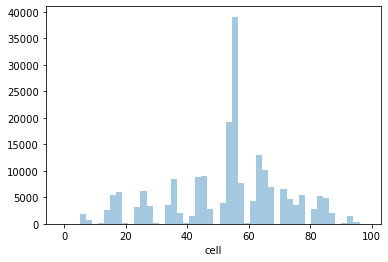

In [10]:
# point = signs_test_df['POINT'].iloc[0]['coordinates']
print('running')

def plot_markers(df, location, tip_col, mapa):
    for idx, row in df.iterrows():
        coords = row[location]['coordinates'][0]
        tooltip = f'Cell: {row["cell"]}, Type: {row[tip_col]}'
        # print(coords, tooltip)

        folium.Marker(coords, tooltip=tooltip).add_to(mapa)

# # /['Regulatory' 'Parking Restrictions' 'Timed Parking' 'Warning' 'Park Plus'
# #  'Pedestrian' 'Street Name' 'Yield' 'Stop' 'Snow Route'
# #  'Guide / Information' nan 'Bicycle / Pathway' 'Disabled Parking'
# #  'Loading Zone' 'Playground' 'Residential Parking' 'Overhead Guide'
# #  'Speed' 'Hospital' 'School' 'Halo']

signs_of_interest = ['Pedestrian', 'Yield', 'Stop', 'Speed', 'Bicycle / Pathway']

filt = signs_test_df['BLADE_TYPE'].isin(signs_of_interest)

plot_signs = signs_test_df.loc[filt]

cell_groups = signs_test_df.groupby(by='cell', as_index=True, sort=True)

display(cell_groups['BLADE_TYPE'].agg('count').sort_values(ascending=False).head(10))

sns.distplot(signs_test_df['cell'], kde = False)



# display(cell_groups.get_group(-1)['POINT'])

# display(cell_groups.get_group(-1))

# plot_markers(cell_groups.get_group(-1),'POINT', m)
    
# plot_markers(plot_signs[['cell', 'POINT', 'BLADE_TYPE']], 'POINT', m)
m.save('index.html')






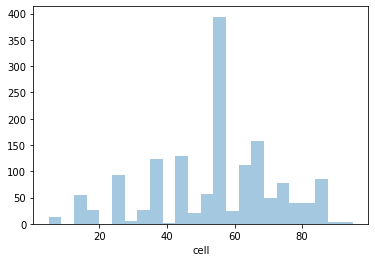

,INSTDATE,FIRSTROAD,SECONDROAD,QUADRANT,INT_TYPE,PEDBUTTONS,PED_TIMER,ACCESSIBLE PEDESTRIAN SIGNAL,latitude,longitude,Point,Count
cell,,,,,,,,,,,,
55,223,223,223,223,223,223,223,0,223,223,223,223
54,77,77,77,77,77,77,75,0,77,77,77,77
35,70,70,70,70,70,70,69,0,70,70,70,70
45,61,61,61,61,61,61,59,0,61,61,61,61
57,56,56,56,56,56,56,56,0,56,56,56,56
65,53,53,53,53,53,53,48,0,53,53,53,53
67,50,50,50,50,50,50,50,0,50,50,50,50
64,49,49,49,49,49,49,47,0,49,49,49,49
63,46,46,46,46,46,46,46,0,46,46,46,46


In [17]:
signals_test_df= signals_df

## TODO: UNCOMMMENT BELOW LINE ON NEW KERNAL RUN
# signals_test_df['Point'] = signals_df['Point'].apply(lambda x: clean_point_coords(x))
# display(signals_test_df)
signals_test_df['cell'] = signals_test_df['Point'].apply(lambda x: place_in_cell(x))
# display(signals_test_df)


plot_markers(signals_test_df,'Point', 'INT_TYPE', m)
m.save('index.html')


plot=sns.distplot(signals_test_df['cell'], kde = False)
plt.show(plot)

cell_groups = signals_test_df.groupby(by='cell', as_index=True, sort=True)

display(cell_groups.agg('count').sort_values(by='INT_TYPE', ascending=False).head(10))

In [12]:
%%html
<iframe src="index.html" frameborder = "0" width = "960" height = "600" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>